### Download dataset

In [4]:
#!wget https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz
#!tar -xvf trainval.tar.gz
#!rm trainval.tar.gz

In [10]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import gzip
import pickle
import os
import csv
import numpy as np
from numpy.random import random_sample
from math import sqrt, log

In [11]:
with open('./trainval/annotations/bbox-annotations.json') as f:
    data = json.load(f)

In [12]:
data.keys()

dict_keys(['images', 'annotations', 'categories', 'licenses'])

In [13]:
data['categories']

[{'id': 1, 'name': 'person', 'supercategory': 'none'},
 {'id': 2, 'name': 'car', 'supercategory': 'none'}]

In [14]:
image_file_data = data['images']
image_file_data
images_df = pd.DataFrame(image_file_data)

In [15]:
anno_data = data['annotations']

In [16]:
col_data = []
for each in anno_data:
    anno_id,image_id,category_id = each['id'],each['image_id'],each['category_id']
    area,iscrowd,license = each['area'],each['iscrowd'],each['license']
    x,y,w,h =each['bbox']
    col_data.append([anno_id,x,y,w,h,area,iscrowd,license,image_id,category_id])

### Filter incorrect annotations!

In [17]:
df = pd.DataFrame(col_data,columns=['anno_id','x','y','w','h','area','iscrowd','license','image_id','category_id'])
df.head()
df = df[df['w']!=0]
df = df[df['h']!=0]

### Generate image level information dataframe

In [18]:
groups = df.groupby(['image_id'])
cat1_ratio = []
avg_areas = []
total_annos = []
image_ids = []
image_data_map = {}
for name,group in groups:
    annos_in_image = group.shape[0]
    avg_area_in_image = group.mean()['area']*100
    category_annos = group[group['category_id']==1].shape[0]
    density = category_annos/annos_in_image*100
    total_annos.append(annos_in_image)
    cat1_ratio.append(density)
    avg_areas.append(avg_area_in_image)
    image_ids.append(name)
image_level_df = pd.DataFrame()
image_level_df['cat1_ratio'] = cat1_ratio
image_level_df['total_annos'] = total_annos
image_level_df['avg_area'] = avg_areas
image_level_df['image_id'] = image_ids

In [19]:
cluster_df = image_level_df[['cat1_ratio','total_annos','avg_area']]
cluster_df

,cat1_ratio,total_annos,avg_area
0,50.000000,4,18.922043
1,33.333333,3,1.403922
2,91.666667,12,8.499776
3,50.000000,2,24.546007
4,90.000000,10,1.271050
...,...,...,...
2234,75.000000,24,1.617828
2235,66.666667,3,8.258792
2236,66.666667,3,25.779054
2237,42.857143,7,15.642056


## Visualize Image Level Details

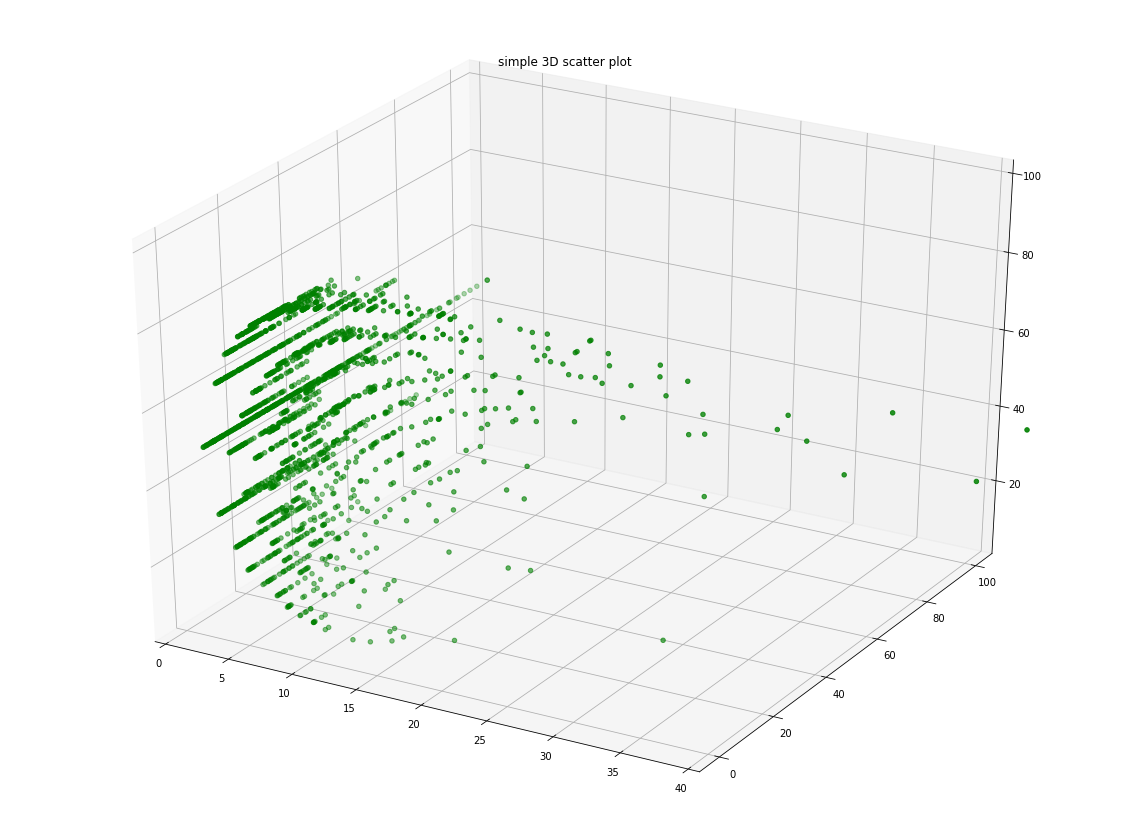

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

R,A,C = cluster_df['cat1_ratio'], cluster_df['avg_area'], cluster_df['total_annos']
fig = plt.figure(figsize = (20, 15))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2)
 
# Creating plot
ax.scatter3D(C, A, R, color = "green")
plt.title("simple 3D scatter plot")
plt.xlim(0,40)
# show plot
plt.show()

## Run clustering and find optimal cluster distribution for stratified sampling

In [59]:
def get_optimal_cluster_count(df, max_k=1000):
    last_gap = float("-inf")
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=3)
        km_act.fit(df)
        ref = df.apply(get_rand_data)
        ref_inertia = iter_kmeans(ref, n_clusters=k).mean()
        gap = log(ref_inertia) - log(km_act.inertia_)
        print("Ref: %s   Act: %s  Gap: %s" % (ref_inertia, km_act.inertia_, gap))
        if last_gap > gap:
            return k - 1
        else:
            last_gap = gap
    return 0

def get_rand_data(col):
    rng = col.max() - col.min()
    return pd.Series(random_sample(len(col)) * rng + col.min())


def iter_kmeans(df, n_clusters, num_iters=5):
    rng = range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = KMeans(n_clusters=n_clusters, n_init=3)
        k.fit(df)
        vals[i] = k.inertia_
    return vals

In [60]:
k = get_optimal_cluster_count(cluster_df)
print("Identified optimal cluster count as {} using peak gap approach".format(k))

<ipython-input-59-525fae5fcc30>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(index=rng)
<ipython-input-59-525fae5fcc30>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(index=rng)


Ref: 4807019.624903614   Act: 1634285.2879409231  Gap: 1.0788716954503368
Ref: 3361328.1422023894   Act: 831679.5986588824  Gap: 1.3966441863856485


<ipython-input-59-525fae5fcc30>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(index=rng)


Ref: 2743337.2960134647   Act: 529269.9670626367  Gap: 1.6454318130845103


<ipython-input-59-525fae5fcc30>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(index=rng)


Ref: 2236821.034357512   Act: 366445.8491915407  Gap: 1.8089601965396849


<ipython-input-59-525fae5fcc30>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(index=rng)


Ref: 1829352.307862047   Act: 308891.94093636906  Gap: 1.7787257430284864
Identified optimal cluster count as 4 using peak gap approach


In [61]:
km_model = KMeans(n_clusters=k,n_init=3)
km_model.fit(cluster_df)

KMeans(n_clusters=4, n_init=3)

In [62]:
image_level_df['data_cluster'] = km_model.predict(cluster_df)

In [63]:
print('Cluster densities')
image_level_df.groupby('data_cluster').count()
image_level_df

Cluster densities


,cat1_ratio,total_annos,avg_area,image_id,data_cluster
0,50.000000,4,18.922043,0,3
1,33.333333,3,1.403922,1,0
2,91.666667,12,8.499776,2,1
3,50.000000,2,24.546007,3,3
4,90.000000,10,1.271050,4,1
...,...,...,...,...,...
2234,75.000000,24,1.617828,2234,1
2235,66.666667,3,8.258792,2235,3
2236,66.666667,3,25.779054,2236,3
2237,42.857143,7,15.642056,2237,3


In [64]:
## Visualise Clusters

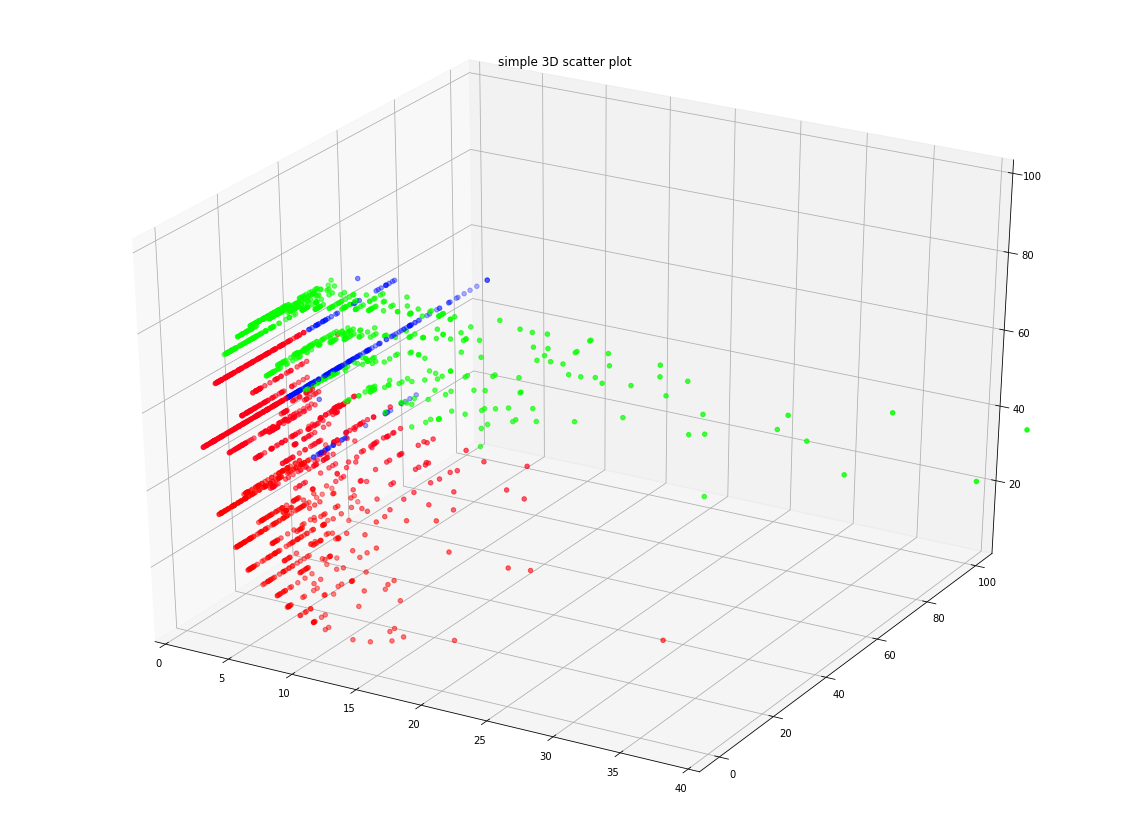

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

R,A,T = image_level_df['cat1_ratio'], image_level_df['avg_area'], image_level_df['total_annos']
C = list(image_level_df['data_cluster'])
cmap = plt.cm.get_cmap('hsv',len(data))
C = [cmap(i) for i in C]
fig = plt.figure(figsize = (20, 15))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3,alpha = 0.2)
 
# Creating plot
ax.scatter3D(T, A, R, color = C)
plt.title("simple 3D scatter plot")
plt.xlim(0,40)
# show plot
plt.show()

In [54]:
complete_df = pd.merge(df,image_level_df,on='image_id')
complete_df = pd.merge(complete_df,images_df,left_on='image_id',right_on='id')

In [55]:
groups = complete_df.groupby(['data_cluster',])
for name,group in groups:
    print(name)

0
1
2
3
4


In [56]:
def split_train_test(df,pk_column='anno_id',stratify_columns=['data_cluster'],split_pct=0.8):
    groups = df.groupby(stratify_columns)
    train_ids = []
    test_ids = []
    for name,group in groups:
        cluster_train_ids = []
        cluster_test_ids = []
        group_name = name
        total_count = group.count()[0]
        train_count = int(total_count*split_pct)
        test_count = total_count-train_count
        image_groups = group.groupby('image_id')
        for name2,group2 in image_groups:
            if len(cluster_train_ids)<train_count:
                cluster_train_ids.extend(group2[pk_column].unique())
            else:
                cluster_test_ids.extend(group2[pk_column].unique())
        train_ids.extend(cluster_train_ids)
        test_ids.extend(cluster_test_ids)
    train_df=df[df[pk_column].isin(train_ids)]
    test_df=df[df[pk_column].isin(test_ids)]
    print(train_df.shape,test_df.shape)
    return train_df,test_df

In [57]:
train_df,test_df = split_train_test(complete_df,split_pct=0.8)

(13416, 19) (3353, 19)


In [58]:
print(train_df.groupby('data_cluster').count()['x'])
print(test_df.groupby('data_cluster').count()['x'])

data_cluster
0    3417
1    6775
2     617
3    2419
4     188
Name: x, dtype: int64
data_cluster
0     855
1    1694
2     155
3     603
4      46
Name: x, dtype: int64


In [59]:
train_df['xmin'] = train_df['x']
train_df['ymin'] = train_df['y']
train_df['xmax'] = train_df['x']+train_df['w']
train_df['ymax'] = train_df['y']+train_df['h']

test_df['xmin'] = test_df['x']
test_df['ymin'] = test_df['y']
test_df['xmax'] = test_df['x']+test_df['w']
test_df['ymax'] = test_df['y']+test_df['h']

<ipython-input-59-bc6b584a63f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['xmin'] = train_df['x']
<ipython-input-59-bc6b584a63f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ymin'] = train_df['y']
<ipython-input-59-bc6b584a63f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [60]:
train_df.to_csv('train.csv',index=False)

In [61]:
test_df.to_csv('test.csv',index=False)

In [62]:
test_df.groupby('category_id').count()

,anno_id,x,y,w,h,area,iscrowd,license_x,image_id,cat1_ratio,...,data_cluster,file_name,width,height,id,license_y,xmin,ymin,xmax,ymax
category_id,,,,,,,,,,,,,,,,,,,,,
1,2134,2134,2134,2134,2134,2134,2134,2134,2134,2134,...,2134,2134,2134,2134,2134,2134,2134,2134,2134,2134
2,1219,1219,1219,1219,1219,1219,1219,1219,1219,1219,...,1219,1219,1219,1219,1219,1219,1219,1219,1219,1219
